In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

# ============================================================
# STEP 1: Load coordinates
# ============================================================
coord_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\lat_long\mandi_coordinates.csv"  # your uploaded file
coords_df = pd.read_csv(coord_file)

# Ensure consistent naming
coords_df.columns = [c.strip().lower() for c in coords_df.columns]
coords_df.rename(columns={'mandi': 'Mandi', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True, errors='ignore')

print(f"✅ Loaded coordinates: {coords_df.shape}")
print(coords_df.head())

# ============================================================
# STEP 2: Match mandis with those from price data
# ============================================================
price_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\only_original_data\price_matrix.parquet"
price_df = pd.read_parquet(price_file)
mandis = list(price_df.columns)

coords_df = coords_df[coords_df['Mandi'].isin(mandis)]
print(f"✅ Filtered coordinates for mandis in price data: {coords_df.shape}")

# ============================================================
# STEP 3: Define Haversine function (distance in km)
# ============================================================
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# ============================================================
# STEP 4: Compute pairwise distance matrix
# ============================================================
mandi_names = coords_df['Mandi'].values
latitudes = coords_df['lat'].values
longitudes = coords_df['lon'].values

n = len(mandi_names)
dist_edges = []

for i in range(n):
    for j in range(i+1, n):
        dist = haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
        dist_edges.append((mandi_names[i], mandi_names[j], dist))

# ============================================================
# STEP 5: Create distance-weighted network
# ============================================================
G_dist = nx.Graph()
G_dist.add_nodes_from(mandi_names)
G_dist.add_weighted_edges_from(dist_edges)

print(f"✅ Distance network created with {G_dist.number_of_nodes()} nodes and {G_dist.number_of_edges()} edges.")

# ============================================================
# STEP 6: Compute basic network metrics
# ============================================================
# Inverse weights for closeness (smaller distance = stronger connection)
for u, v, d in G_dist.edges(data=True):
    d['inv_weight'] = 1 / (d['weight'] + 1e-6)

closeness = nx.closeness_centrality(G_dist, distance='weight')
betweenness = nx.betweenness_centrality(G_dist, weight='weight')
degree = dict(G_dist.degree())

stats_dist_df = pd.DataFrame({
    'Degree': degree,
    'Closeness Centrality': closeness,
    'Betweenness Centrality': betweenness
}).sort_values(by='Closeness Centrality', ascending=False)

print("\n🔝 Top 10 Mandis by Closeness Centrality (proximity-based):\n")
print(stats_dist_df.head(10).round(4))

# ============================================================
# STEP 7: Visualization
# ============================================================
plt.figure(figsize=(12, 9))
pos = {row['Mandi']: (row['lon'], row['lat']) for _, row in coords_df.iterrows()}

# Scale edge widths inversely to distance (closer = thicker)
weights = np.array([d['weight'] for _, _, d in G_dist.edges(data=True)])
scaled_widths = 1 + 6 * (1 - (weights - weights.min()) / (weights.max() - weights.min()))

nx.draw_networkx_nodes(G_dist, pos, node_color='lightgreen', node_size=500, edgecolors='black')
nx.draw_networkx_edges(G_dist, pos, width=scaled_widths, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G_dist, pos, font_size=8)

plt.title("Mandi Distance Network (Weighted by Real Distance in km)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# ============================================================
# STEP 8: Save outputs
# ============================================================
edges_df = pd.DataFrame(dist_edges, columns=['Mandi1', 'Mandi2', 'Distance_km'])
edges_df.to_csv("mandi_distance_network_edges.csv", index=False)
stats_dist_df.to_csv("mandi_distance_network_stats.csv")
print("✅ Saved: distance-based edges and network stats.")


✅ Loaded coordinates: (1629, 3)
                    Mandi        lat        lon
0              Naharlagun  27.130855  93.709712
1                   Howly  26.424963  90.971203
2                Gauripur  26.086536  89.964662
3               Dibrugarh  27.484460  94.901945
4  P.O. Uparhali Guwahati        NaN        NaN
✅ Filtered coordinates for mandis in price data: (1600, 3)
✅ Distance network created with 1600 nodes and 1279200 edges.


⚠️ The following mandis were dropped due to missing coordinates:
['P.O. Uparhali Guwahati', 'Ahmedabad(Chimanbhai Patal Market Vasana)', 'Khambhat(Veg Yard Khambhat)', 'Deesa(Deesa Veg Yard)', 'Dahod(Veg. Market)', 'Nadiyad(Piplag)', 'Mehsana(Mehsana Veg)', 'Rajkot(Veg.Sub Yard)', 'Vadodara(Sayajipura)', 'Iamailabad', 'Mohindergarh', 'Panchkul(Kalka)', 'Bapauli', 'Chhachrauli', 'Parimpore', 'Chikkamagalore', 'Kanjangadu', 'Thirurrangadi', 'Bhopal(F&V)', 'Damoh(F&V)', 'Dewas(F&V)', 'Badnawar(F&V)', 'Indore(F&V)', 'Khandwa(F&V)', 'Ujjain(F&V)', 'Newasa(Ghodegaon)', 'Rahuri(Vambori)', 'Amrawati(Frui & Veg. Market)', 'Chandrapur(Ganjwad)', 'Chattrapati Sambhajinagar', 'Vaijpur', 'Dindori(Vani)', 'Kalvan', 'Pimpalgaon Baswant(Saykheda)', 'Sangli(Phale, Bhajipura Market)', 'Mangal Wedha', 'Angul(Atthamallick)', 'Bargarh(Barapalli)', 'Kendupatna', 'Kendupatna(Niali)', 'Mottagaon', 'Chatta Krushak Bazar', 'Kendrapara(Marshaghai)', 'Keonjhar(Jhumpura)', 'Aiginia Mandi', 'Damana Hat', 'Bahadajho

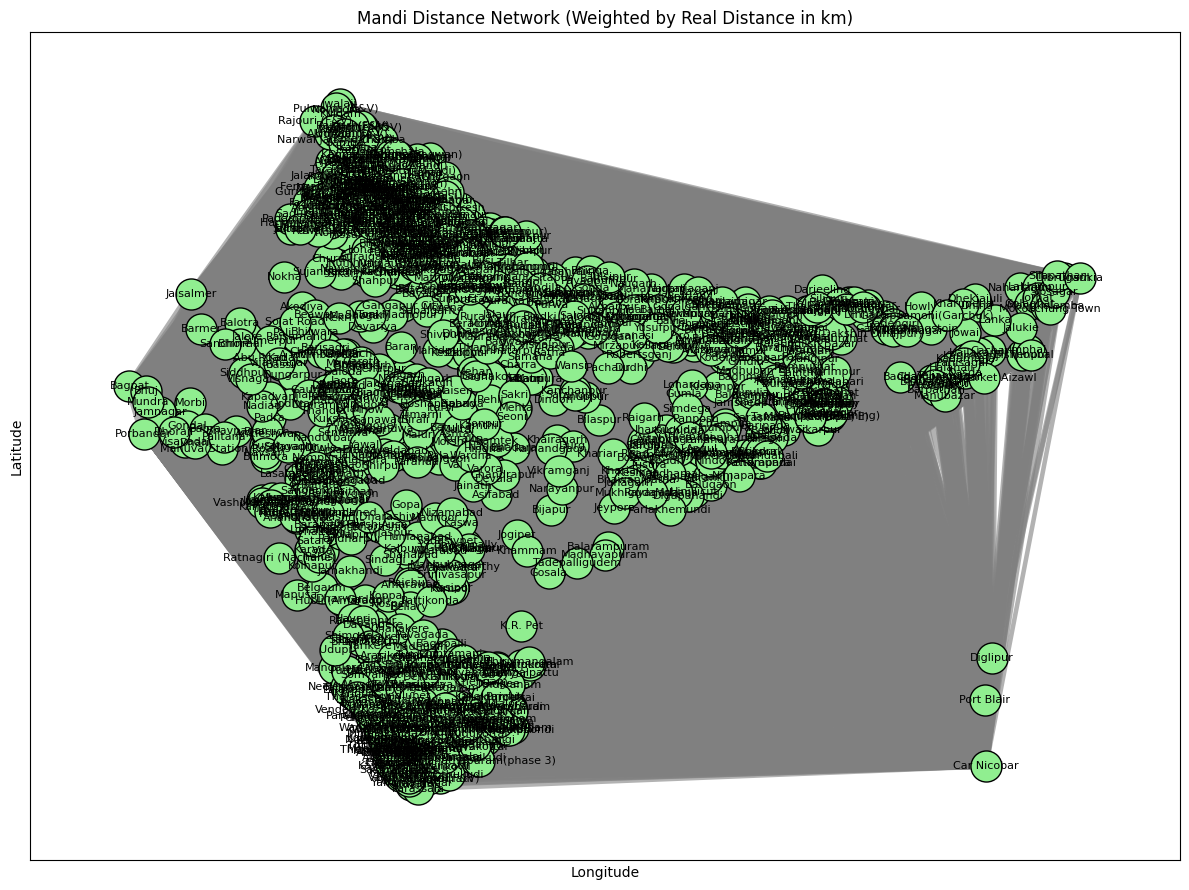

✅ Saved new files:
 - c:\Users\PESU-RF\Downloads\Onions\Onions\mandi_distance_network_edges_new.csv
 - c:\Users\PESU-RF\Downloads\Onions\Onions\mandi_distance_network_stats_new.csv


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import os

# ============================================================
# STEP 1: Load and clean coordinates
# ============================================================
coord_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\lat_long\mandi_coordinates.csv"   # your uploaded coordinates file
coords_df = pd.read_csv(coord_file)

# Normalize column names
coords_df.columns = [c.strip().lower() for c in coords_df.columns]
coords_df.rename(columns={'mandi': 'Mandi', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True)

# Drop missing coordinates
missing_coords = coords_df[coords_df['lat'].isna() | coords_df['lon'].isna()]
if not missing_coords.empty:
    print("⚠️ The following mandis were dropped due to missing coordinates:")
    print(missing_coords['Mandi'].tolist())

coords_df = coords_df.dropna(subset=['lat', 'lon'])
print(f"✅ Coordinates after cleaning: {coords_df.shape}")

# ============================================================
# STEP 2: Load mandis from price data and align
# ============================================================
price_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\only_original_data\price_matrix.parquet"
price_df = pd.read_parquet(price_file)
mandis = list(price_df.columns)

coords_df = coords_df[coords_df['Mandi'].isin(mandis)]
print(f"✅ Filtered coordinates for mandis in price data: {coords_df.shape}")

# ============================================================
# STEP 3: Define Haversine formula (great-circle distance in km)
# ============================================================
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# ============================================================
# STEP 4: Compute pairwise distance matrix
# ============================================================
mandi_names = coords_df['Mandi'].values
latitudes = coords_df['lat'].values
longitudes = coords_df['lon'].values
n = len(mandi_names)

dist_edges = []
for i in range(n):
    for j in range(i+1, n):
        dist = haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
        dist_edges.append((mandi_names[i], mandi_names[j], dist))

print(f"✅ Computed distances for {len(dist_edges)} mandi pairs.")

# ============================================================
# STEP 5: Create distance-weighted network
# ============================================================
G_dist = nx.Graph()
G_dist.add_nodes_from(mandi_names)
G_dist.add_weighted_edges_from(dist_edges)

print(f"✅ Distance network created with {G_dist.number_of_nodes()} nodes and {G_dist.number_of_edges()} edges.")

# ============================================================
# STEP 6: Compute network metrics
# ============================================================
for u, v, d in G_dist.edges(data=True):
    d['inv_weight'] = 1 / (d['weight'] + 1e-6)

degree = dict(G_dist.degree())
closeness = nx.closeness_centrality(G_dist, distance='weight')
betweenness = nx.betweenness_centrality(G_dist, weight='weight')

stats_dist_df = pd.DataFrame({
    'Degree': degree,
    'Closeness Centrality': closeness,
    'Betweenness Centrality': betweenness
}).sort_values(by='Closeness Centrality', ascending=False)

print("\n🔝 Top 10 Mandis by Closeness Centrality (physically central):\n")
print(stats_dist_df.head(10).round(4))

# ============================================================
# STEP 7: Visualization
# ============================================================
plt.figure(figsize=(12, 9))
pos = {row['Mandi']: (row['lon'], row['lat']) for _, row in coords_df.iterrows()}

weights = np.array([d['weight'] for _, _, d in G_dist.edges(data=True)])
scaled_widths = 1 + 6 * (1 - (weights - weights.min()) / (weights.max() - weights.min()))

nx.draw_networkx_nodes(G_dist, pos, node_color='lightgreen', node_size=500, edgecolors='black')
nx.draw_networkx_edges(G_dist, pos, width=scaled_widths, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G_dist, pos, font_size=8)

plt.title("Mandi Distance Network (Weighted by Real Distance in km)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

# Save figure to a new file
plt.savefig("mandi_distance_network_plot.png", dpi=300)
plt.show()

# ============================================================
# STEP 8: Save results to NEW files (no overwriting)
# ============================================================
edges_df = pd.DataFrame(dist_edges, columns=['Mandi1', 'Mandi2', 'Distance_km'])

# Safe new filenames
edges_path = "mandi_distance_network_edges_new.csv"
stats_path = "mandi_distance_network_stats_new.csv"

edges_df.to_csv(edges_path, index=False)
stats_dist_df.to_csv(stats_path)

print(f"✅ Saved new files:\n - {os.path.abspath(edges_path)}\n - {os.path.abspath(stats_path)}")


In [ ]:
## REVIEW ONCE TO SEE IF IMPORTANT

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

# ============================================================
# STEP 1: Load coordinates
# ============================================================
coord_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\lat_long\mandi_coordinates.csv"  # your uploaded file
coords_df = pd.read_csv(coord_file)

# Ensure consistent naming
coords_df.columns = [c.strip().lower() for c in coords_df.columns]
coords_df.rename(columns={'mandi': 'Mandi', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True, errors='ignore')

print(f"✅ Loaded coordinates: {coords_df.shape}")
print(coords_df.head())

# ============================================================
# STEP 2: Match mandis with those from price data
# ============================================================
price_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\only_original_data\price_matrix.parquet"
price_df = pd.read_parquet(price_file)
mandis = list(price_df.columns)

coords_df = coords_df[coords_df['Mandi'].isin(mandis)]
print(f"✅ Filtered coordinates for mandis in price data: {coords_df.shape}")

# ============================================================
# STEP 3: Define Haversine function (distance in km)
# ============================================================
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# ============================================================
# STEP 4: Compute pairwise distance matrix
# ============================================================
mandi_names = coords_df['Mandi'].values
latitudes = coords_df['lat'].values
longitudes = coords_df['lon'].values

n = len(mandi_names)
dist_edges = []

for i in range(n):
    for j in range(i+1, n):
        dist = haversine(latitudes[i], longitudes[i], latitudes[j], longitudes[j])
        dist_edges.append((mandi_names[i], mandi_names[j], dist))

# ============================================================
# STEP 5: Create distance-weighted network
# ============================================================
G_dist = nx.Graph()
G_dist.add_nodes_from(mandi_names)
G_dist.add_weighted_edges_from(dist_edges)

print(f"✅ Distance network created with {G_dist.number_of_nodes()} nodes and {G_dist.number_of_edges()} edges.")

# ============================================================
# STEP 6: Compute basic network metrics
# ============================================================
# Inverse weights for closeness (smaller distance = stronger connection)
for u, v, d in G_dist.edges(data=True):
    d['inv_weight'] = 1 / (d['weight'] + 1e-6)

closeness = nx.closeness_centrality(G_dist, distance='weight')
betweenness = nx.betweenness_centrality(G_dist, weight='weight')
degree = dict(G_dist.degree())

stats_dist_df = pd.DataFrame({
    'Degree': degree,
    'Closeness Centrality': closeness,
    'Betweenness Centrality': betweenness
}).sort_values(by='Closeness Centrality', ascending=False)

print("\n🔝 Top 10 Mandis by Closeness Centrality (proximity-based):\n")
print(stats_dist_df.head(10).round(4))

# ============================================================
# STEP 7: Visualization
# ============================================================
plt.figure(figsize=(12, 9))
pos = {row['Mandi']: (row['lon'], row['lat']) for _, row in coords_df.iterrows()}

# Scale edge widths inversely to distance (closer = thicker)
weights = np.array([d['weight'] for _, _, d in G_dist.edges(data=True)])
scaled_widths = 1 + 6 * (1 - (weights - weights.min()) / (weights.max() - weights.min()))

nx.draw_networkx_nodes(G_dist, pos, node_color='lightgreen', node_size=500, edgecolors='black')
nx.draw_networkx_edges(G_dist, pos, width=scaled_widths, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G_dist, pos, font_size=8)

plt.title("Mandi Distance Network (Weighted by Real Distance in km)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# ============================================================
# STEP 8: Save outputs
# ============================================================
edges_df = pd.DataFrame(dist_edges, columns=['Mandi1', 'Mandi2', 'Distance_km'])
edges_df.to_csv("mandi_distance_network_edges.csv", index=False)
stats_dist_df.to_csv("mandi_distance_network_stats.csv")
print("✅ Saved: distance-based edges and network stats.")


✅ Loaded coordinates: (1629, 3)
                    Mandi        lat        lon
0              Naharlagun  27.130855  93.709712
1                   Howly  26.424963  90.971203
2                Gauripur  26.086536  89.964662
3               Dibrugarh  27.484460  94.901945
4  P.O. Uparhali Guwahati        NaN        NaN
✅ Filtered coordinates for mandis in price data: (1600, 3)
✅ Distance network created with 1600 nodes and 1279200 edges.


KeyboardInterrupt: 